In [ ]:
library(DESeq2)
library(dplyr)
library(stringr)
library(clusterProfiler)
library(org.Hs.eg.db)
library(edgeR)
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) 
library(pheatmap)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(DT)
library(ggpubr)
library(corrplot)
library(ggthemes)

In [6]:
library(DT)

In [7]:
scale_rows = function(x){
    m = apply(x, 1, mean, na.rm = T)
    s = apply(x, 1, sd, na.rm = T)
    return((x - m) / s)
}
scale_mat = function(mat, scale){
    if(!(scale %in% c("none", "row", "column"))){
        stop("scale argument shoud take values: 'none', 'row' or 'column'")
    }
    mat = switch(scale, none = mat, row = scale_rows(mat), column = t(scale_rows(t(mat))))
    return(mat)
}

In [8]:
deseq <- function(data_for_compare,coldata_for_compare){
 
    dds_compare <- DESeqDataSetFromMatrix(data_for_compare, coldata_for_compare, design= ~ group)
    dds_compare <- DESeq(dds_compare)
    res = results(dds_compare)
    res = res[order(res$pvalue),]
    diff_res <- subset(res, padj < 0.05 & abs(log2FoldChange) > log2(2))
    diff = as.data.frame(diff_res)
    allres = as.data.frame(res)

    diff_name=rownames(diff)
    all_name=rownames(allres)
    compare <- mcols(res)$description[2] %>% strsplit(split = ":") %>% .[[1]] %>% .[2]
    compare2 <- compare %>% strsplit(split=" group ") %>% .[[1]] %>% .[2] %>% strsplit(split=" vs ") %>% .[[1]]
    
    diff$category = NA
    diff[diff$log2FoldChange>0,]$category = compare2[1]
    diff[diff$log2FoldChange<0,]$category = compare2[2]
    allres <- allres[!is.na(allres$padj),]
    allres$category = NA
    allres[allres$log2FoldChange>0,]$category = compare2[1]
    allres[allres$log2FoldChange<0,]$category = compare2[2]
    return(list(all=allres,diff=diff,dds=dds_compare))
}

### read the data

In [9]:
#saveRDS(object = ,file = "")

In [10]:
data_Tumor_raw <- readRDS("../00.data/Tumor.raw.Rdata")
data_Normal_raw <- readRDS("../00.data/Normal.raw.Rdata")

### convert to integers

In [11]:
data_Tumor_raw <- mutate_all(data_Tumor_raw, function(x) as.integer(x))
data_Normal_raw <- mutate_all(data_Normal_raw, function(x) as.integer(x))

### read the phe

In [12]:
 phe <- readRDS("../00.data/phe_RNA54.Rdata")

### divide the data into three group

In [13]:
Low_tumor <- filter(phe,group=="Low") %>% .[,'sample'] %>% data_Tumor_raw[,.] 
High_tumor <- filter(phe,group=="High") %>% .[,'sample'] %>% data_Tumor_raw[,.] 
Neg_tumor <- filter(phe,group=="negative") %>% .[,'sample'] %>% data_Tumor_raw[,.] 

In [14]:
High_normal <- filter(phe,group=="High") %>% .[,'sample'] %>% data_Normal_raw[,.] 
Neg_normal <- filter(phe,group=="negative") %>% .[,'sample'] %>% data_Normal_raw[,.] 
Low_normal <- filter(phe,group=="Low") %>% .[,'sample'] %>% data_Normal_raw[,.] 

In [15]:
Low_tumor %>% colnames() %>% paste0('T') -> colnames(Low_tumor)
High_tumor %>% colnames() %>% paste0('T') -> colnames(High_tumor)
Neg_tumor %>% colnames() %>% paste0('T') -> colnames(Neg_tumor)
High_normal %>% colnames() %>% paste0('N') -> colnames(High_normal)
Neg_normal %>% colnames() %>% paste0('N') -> colnames(Neg_normal)
Low_normal %>% colnames() %>% paste0('N') -> colnames(Low_normal)

### Merge the tumor and normal

In [16]:
data_High <- cbind(High_tumor,High_normal)
data_Low <- cbind(Low_tumor,Low_normal)
data_Neg <- cbind(Neg_tumor,Neg_normal)

### create the coldata for deseq2

In [17]:
coldata_high <- data.frame(name = colnames(data_High),
                      group = c(rep("tumor",ncol(data_High)/2),
                                rep("normal",ncol(data_High)/2)))
rownames(coldata_high) <- coldata_high$name
coldata_low <- data.frame(name = colnames(data_Low),
                      group = c(rep("tumor",ncol(data_Low)/2),
                                rep("normal",ncol(data_Low)/2)))

rownames(coldata_low) <- coldata_low$name

coldata_neg <- data.frame(name = colnames(data_Neg),
                      group = c(rep("tumor",ncol(data_Neg)/2),
                                rep("normal",ncol(data_Neg)/2)))

rownames(coldata_neg) <- coldata_neg$name

### Do the deseq2

In [18]:
rlt_high_tn <- deseq(data_High, coldata_high)
rlt_low_tn <- deseq(data_Low, coldata_low)
rlt_neg_tn <- deseq(data_Neg, coldata_neg)

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [46]:
save(rlt_high_tn,rlt_low_tn,rlt_neg_tn,file = "Deseq2_TvsN_FC2.Rdata")

In [20]:
load("Deseq2_TvsN_FC2.Rdata")

### volcano plot

In [21]:
library(ggrastr)

In [53]:
plot_valcano <- function(mydata,name,gcolor){
    
    mydata$logP <- -log10(mydata$padj)
    mydata %>% mutate(group = case_when(padj<=0.05&log2FoldChange>log2(2) ~ name, 
                                                  padj<=0.05&log2FoldChange<(-log2(2)) ~ "Normal",
                                                  padj>0.05|abs(log2FoldChange)<log2(2) ~"NoSig" )) -> mydata
    mytable <- table(mydata$group)
    p_high <- ggscatter(mydata, x = "log2FoldChange", y = "logP", color = "group", 
            palette = c("#2f5688","#BBBBBB", gcolor ), size = 1, ## blue, grey,red 
            xlab = "log2FoldChange", ylab = "-log10(Adjust P-value)")+xlim(-3,3)+
    theme_base()+geom_hline(yintercept = -log10(0.05), linetype="dashed")+ylim(0,20)+
    geom_vline(xintercept = c(-log2(2),log2(2)), linetype="dashed")+
    annotate("text", x = 2, y = 15, label = mytable[3])+ 
    annotate("text", x = -2, y = 15, label = mytable[1])
    return(p_high)
}


In [54]:
p_high <- rasterize(plot_valcano(rlt_high_tn$all,'Tumor','#ED2224'),dpi=300)

In [55]:
p_low <- rasterize(plot_valcano(rlt_low_tn$all,'Tumor','#65B045'),dpi=300)

In [56]:
p_neg <- rasterize(plot_valcano(rlt_neg_tn$all,'Tumor','#0B85A3'),dpi=300)

In [57]:
p_volcano <- ggarrange(p_high,p_low,p_neg,ncol=3,labels = c("High_vs_NATs","Low_vs_NATs","Neg_vs_NATs"))

Warning message:
“Removed 746 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1014 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 611 rows containing missing values (`geom_point()`).”


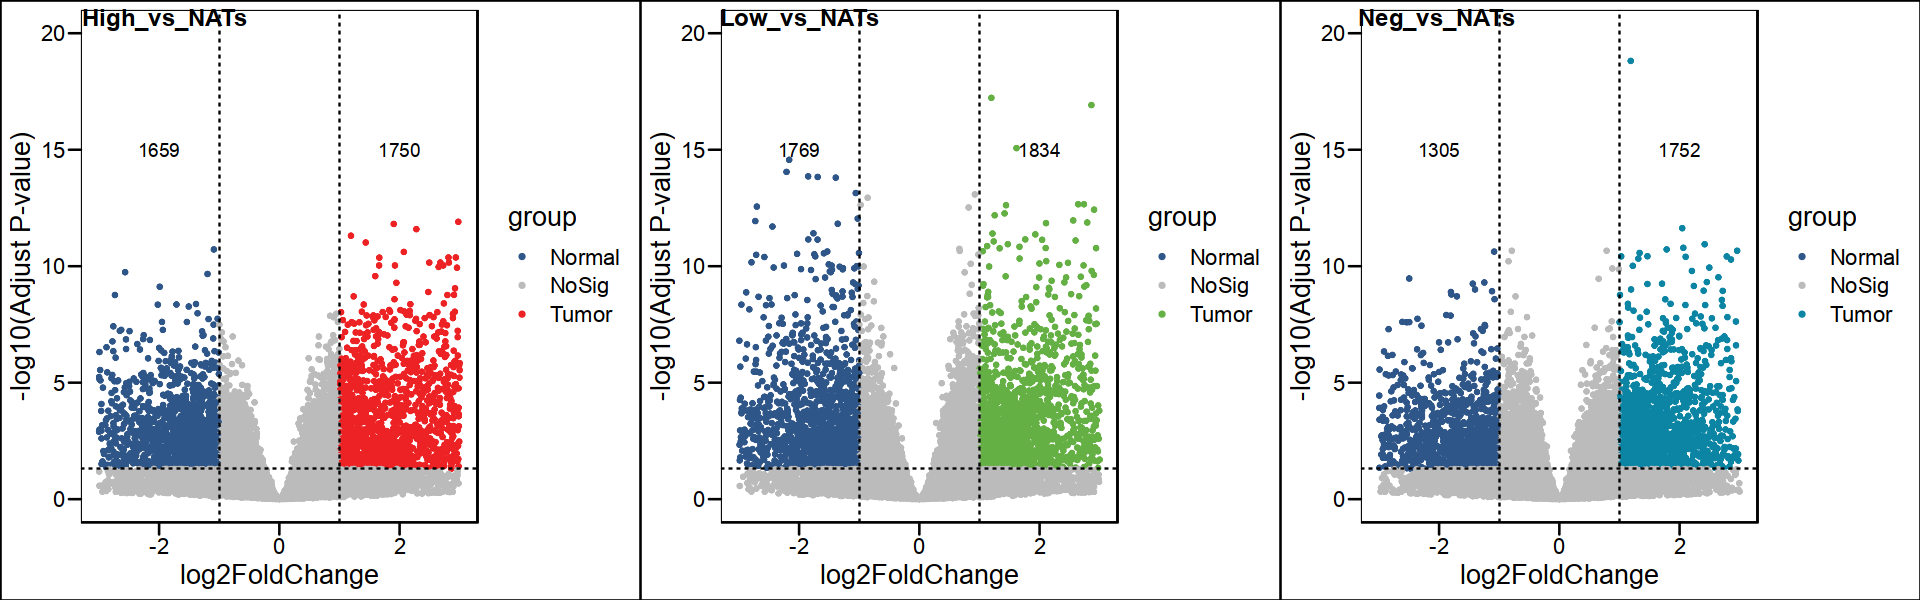

In [58]:
options(repr.plot.width =16,repr.plot.height=5)
p_volcano

In [59]:
ggsave(filename = "Tumor_vs_Normal_volcano.FC2.pdf",plot = p_volcano,width = 14,height = 4)

In [114]:
openxlsx::write.xlsx(list('High_vs_Normal' = rlt_high_tn$diff,
                          'Low_vs_Normal' = rlt_low_tn$diff,
                          'Neg_vs_Normal' = rlt_neg_tn$diff),
           rowNames = TRUE, file = "Diffgene_TumorvsNormal.FC2.xlsx")

In [115]:
openxlsx::write.xlsx(list('High_vs_Normal' = rlt_high_tn$all,
                          'Low_vs_Normal' = rlt_low_tn$all,
                          'Neg_vs_Normal' = rlt_neg_tn$all),
           rowNames = TRUE, file = "Allgene_TumorvsNormal.FC2.xlsx")

### pheatmap

In [60]:
plot_heatmap <- function(for_high_heatmap_scale){
    temp <- data.frame(group= c(rep("Tumor",ncol(for_high_heatmap_scale)/2),
                                rep("Normal",ncol(for_high_heatmap_scale)/2)))
    temp$group <- factor(temp$group,levels=c("Tumor","Normal"))
    col_fun = colorRamp2(c(min(for_high_heatmap_scale), 0, max(for_high_heatmap_scale)), 
                         c("#534ED9","white","#FF1800"))
    column_ha = HeatmapAnnotation(group = c(rep("Tumor",ncol(for_high_heatmap_scale)/2),
                                            rep("Normal",ncol(for_high_heatmap_scale)/2)),
                              col = list(group = c("Tumor" = "red", "Normal" = "#A65E00")))
#ha = rowAnnotation(foo = anno_mark(at = match(c("ERBB2","H2AX"), rownames(for_high_heatmap_scale)), 
#    labels = c("ERBB2","H2AX")))
    p_high <- Heatmap(as.matrix(for_high_heatmap_scale), cluster_rows = FALSE,
        cluster_columns = FALSE, border = "white",gap = 1,
        show_row_names = F,show_column_names = F,col = col_fun,
        column_split = temp$group,
   #     row_split = forrowsplit$group,
        top_annotation  = column_ha)
 return(p_high)
}


In [61]:
options(repr.plot.height=4,repr.plot.width=5)
rlt_high_tn$diff %>% arrange(desc(category)) %>% rownames() %>% data_High[.,] %>%  scale_mat(.,'row') -> for_high_heatmap_scale

In [62]:
rlt_low_tn$diff %>% arrange(desc(category)) %>% rownames() %>% data_Low[.,] %>%  scale_mat(.,'row') -> for_low_heatmap_scale

In [63]:
rlt_neg_tn$diff %>% arrange(desc(category)) %>% rownames() %>% data_Neg[.,] %>%  scale_mat(.,'row') -> for_neg_heatmap_scale

In [64]:
head(for_high_heatmap_scale)

,9DW0073T,9DW0079T,9DW0076T,9DW0126T,9DW0169T,9DW0192T,9DW0193T,9DW0201T,9DW0219T,9DW0227T,⋯,9DW0227N,9DW0230N,9DW0274N,9DW0312N,9DW0330N,9DW0344N,9DW0351N,9DW0362N,9DW0368N,9DW0383N
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PPP1R1B,-0.2604968,0.4271023,-0.18395144,-0.24146949,0.2285073,-0.2028780,-0.25955713,0.22102396,-0.2624767,-0.2541207715,⋯,-0.2578792,-0.2617384,-0.2615035,-0.2578121,-0.2002941,-0.2332814,-0.2617048,-0.2575772,-0.2598256,-0.2587517
ESM1,-0.4486282,0.3320552,0.09704534,-0.45345717,-0.4534572,0.1388964,-0.33917156,0.42380561,-0.3826323,0.0004659532,⋯,-0.4711634,-0.4743827,-0.4936986,-0.3987289,-0.4389703,-0.4148254,-0.4727731,-0.4615055,-0.4502379,-0.4759924
NEU4,-0.2313220,-0.1431903,-0.23011473,0.82384441,-0.1842379,-0.2433949,-0.25184585,0.07653547,-0.2482240,0.2455552604,⋯,-0.2433949,-0.2506386,-0.2530531,-0.2506386,-0.2325293,-0.2409803,-0.2494313,-0.2470167,-0.2470167,-0.2542604
PRAME,-0.3281982,0.2968558,-0.10772461,0.02562023,-0.3463816,-0.1834887,0.07562455,5.07908655,-0.2797091,-0.2577375487,⋯,-0.3516850,-0.3516850,-0.3524427,-0.3471392,-0.2872856,-0.3372899,-0.3501698,-0.3501698,-0.3524427,-0.3516850
HOXC9,-0.5457313,1.1583681,-0.21132473,-0.37623758,-0.4312085,1.0988163,-0.43578944,3.68245094,-0.1151256,-0.4724367450,⋯,-0.5869596,-0.5961214,-0.6007023,-0.4815986,-0.5274077,-0.6007023,-0.6007023,-0.5915405,-0.5915405,-0.6007023
METTL7B,-0.6569764,1.6901701,-0.55865567,0.49149367,-0.2176709,0.7969156,-0.34109485,0.28857637,-0.6214136,-0.2218547828,⋯,-0.6486087,-0.6381490,-0.6339652,-0.6653441,-0.2197629,-0.5963104,-0.5837588,-0.6172297,-0.6507006,-0.6235055


`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



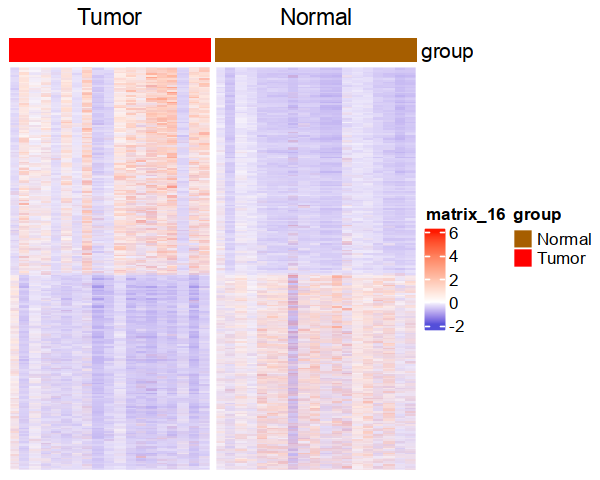

In [121]:
plot_heatmap(for_high_heatmap_scale)

In [64]:
while (!is.null(dev.list())) dev.off()

In [65]:
dev.list()

png 
  2

In [ ]:
pdf(file = "High_vs_Normal.heatmap.FC2.pdf",width = 6,height = 4)
plot_heatmap(for_high_heatmap_scale)
dev.off()

In [ ]:
pdf(file = "Low_vs_Normal.heatmap.FC2.pdf",width = 6,height = 4)
plot_heatmap(for_low_heatmap_scale)
dev.off()

In [ ]:
pdf(file = "Neg_vs_Normal.heatmap.FC2.pdf",width = 6,height = 4)
plot_heatmap(for_neg_heatmap_scale)
dev.off()

### venn_plot

In [65]:
library(ggvenn)
library(RColorBrewer )
library(VennDiagram)
library(eulerr)

Loading required package: futile.logger


Attaching package: ‘VennDiagram’


The following object is masked from ‘package:ggpubr’:

    rotate




In [66]:
x <- list(Neg=rlt_neg_tn$diff %>% rownames(), Low=rlt_low_tn$diff %>% rownames(),High=rlt_high_tn$diff %>% rownames())

In [107]:
neg_genes <- rlt_neg_tn$diff  %>% filter(category=="tumor") %>% rownames()
low_genes <- rlt_low_tn$diff %>% filter(category=="tumor") %>%rownames()
high_genes <- rlt_high_tn$diff %>% filter(category=="tumor") %>%rownames()

In [108]:
neg_unique_genes <- neg_genes %>% setdiff(c(low_genes,high_genes))
low_unique_genes <- low_genes %>% setdiff(c(neg_genes,high_genes))
high_unique_genes <- high_genes %>% setdiff(c(low_genes,neg_genes))

In [109]:
high_neg_genes <- intersect(neg_genes,high_genes)
low_neg_genes <- intersect(neg_genes,low_genes)
high_low_genes <- intersect(high_genes,low_genes)

In [110]:
high_low_neg_genes <- intersect(neg_genes,high_genes) %>% intersect(low_genes)

In [111]:
# Input in the form of a named numeric vector
fit1 <- euler(c("Neg" = length(neg_unique_genes), "Low" = length(low_unique_genes) , "High" = length(high_unique_genes),
                "High&Low" = length(high_low_genes), "High&Neg" = length(high_neg_genes), "Neg&Low" = length(low_neg_genes),
                "High&Low&Neg" = length(high_low_neg_genes)))

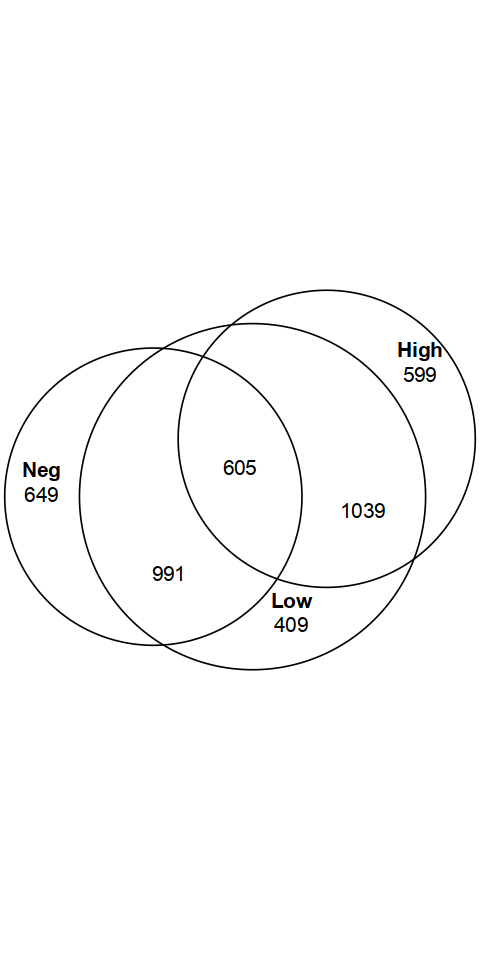

In [112]:
plot(fit1,quantities = TRUE, fill = "transparent")

In [113]:
pdf(file = "RNAseq.T_vs_N.Venn.pdf",width = 4,height = 4)
ggvenn(data = list(high=high_genes,low=low_genes,neg=neg_genes),show_percentage = FALSE,
             fill_color = c("#ED2224FF", "#65B045FF", "#0B85A3FF", "#0B85A3FF"))
dev.off()

png 
  2

In [114]:
high_sig_genes <- high_genes
low_sig_genes <- low_genes
neg_sig_genes <- neg_genes

In [115]:
low_sig_genes %>% intersect(neg_sig_genes) %>% intersect(high_sig_genes) -> union_1055
low_sig_genes %>% intersect(neg_sig_genes) %>% setdiff(union_62) -> low_neg_762
high_sig_genes %>% intersect(neg_sig_genes) %>% setdiff(union_62) -> high_neg_247
high_sig_genes %>% intersect(low_sig_genes) %>% setdiff(union_62) -> high_low_866
high_sig_genes %>% setdiff(low_sig_genes) %>% setdiff(neg_sig_genes) -> high_1241
low_sig_genes %>% setdiff(neg_sig_genes) %>% setdiff(high_sig_genes) -> low_920
neg_sig_genes %>% setdiff(low_sig_genes) %>% setdiff(high_sig_genes) -> neg_993

In [116]:
openxlsx::write.xlsx(list("union_1055" = union_1055,"low_neg_762" = low_neg_762 ,"high_neg_247" = high_neg_247,"high_low_866" = high_low_866,
               "high_1241" = high_1241,"low_920" = low_920,"neg_993"= neg_993),
           rowNames = FALSE, file = "T_vs_N_venn.genes.xlsx")

In [84]:
?ggvenn

### HLA gene

In [74]:
high_HLA <- rlt_high_tn$diff %>% rownames() %>% str_detect('HLA') %>% rlt_high_tn$diff[.,] %>% filter(category=="tumor")
low_HLA <- rlt_low_tn$diff %>% rownames() %>% str_detect('HLA') %>% rlt_low_tn$diff[.,] %>% filter(category=="tumor")
neg_HLA <- rlt_neg_tn$diff %>% rownames() %>% str_detect('HLA') %>% rlt_neg_tn$diff[.,]%>% filter(category=="tumor")

In [75]:
HLA_names <- unique(c(rownames(high_HLA),rownames(low_HLA),rownames(neg_HLA)))

In [76]:
HLA_names[-3] -> HLA_names

In [77]:
neg_HLA$padj2 <- -log10(neg_HLA$padj)
high_HLA$padj2 <- -log10(high_HLA$padj)
low_HLA$padj2 <- -log10(low_HLA$padj)

In [78]:
HLA_matrix <- data.frame(High = HLA_names %in% rownames(high_HLA) %>% ifelse(high_HLA$padj2,0),
           Low = HLA_names %in% rownames(low_HLA) %>% ifelse(low_HLA$padj2,0),
          Neg = HLA_names %in% rownames(neg_HLA) %>% ifelse(neg_HLA$padj2,0),row.names=HLA_names)

In [79]:
HLA_matrix[c('HLA-A','HLA-B','HLA-C','HLA-G','HLA-F','HLA-H','HLA-DRB1','HLA-DMB','HLA-DRA',
             'HLA-DQB1','HLA-DQA1'),] -> HLA_matrix2

In [80]:
options(repr.plot.height=8,repr.plot.width=4)
pheatmap::pheatmap(HLA_matrix2,color =colorRampPalette(c("white","red"))(50),
                   cluster_cols = F,cluster_rows = F,
         width = 3,height = 6,filename = "HLA.heatmap.FC2.pdf")

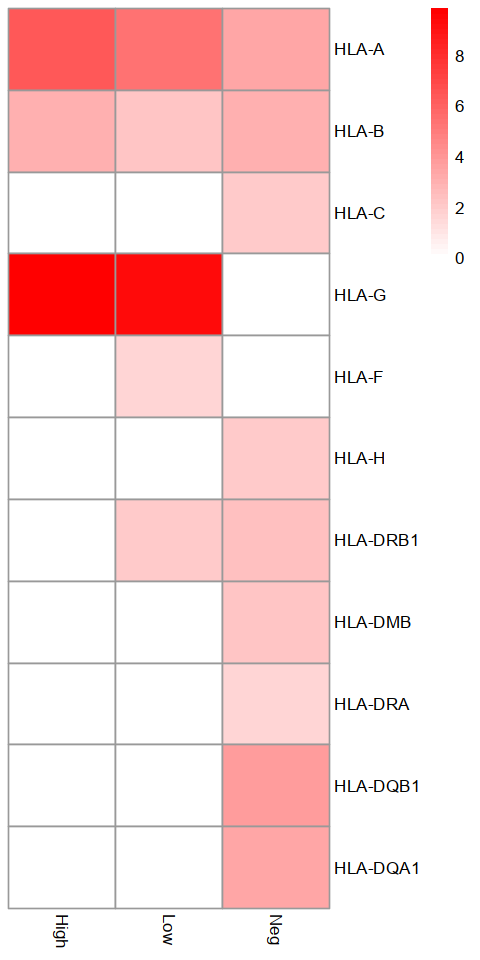

In [81]:
options(repr.plot.height=8,repr.plot.width=4)
pheatmap::pheatmap(HLA_matrix2,color =colorRampPalette(c("white","red"))(50),
                   cluster_cols = F,cluster_rows = F)

In [82]:
save.image('RNAseq_T_N.Rdata')